In [1]:
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
import pathlib
import os
os.environ['VXM_BACKEND'] = 'pytorch'
from voxelmorph.torch import networks,layers
import nibabel as nib
from torch.utils.data import DataLoader,Dataset
import torch.nn.functional as nnf
import subprocess
from joblib import Parallel, delayed
import io
import re
from itertools import combinations
import pandas as pd
from voxelmorph.py import utils
import seaborn as sns 
import tractseg
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats import multicomp

In [2]:
backbone_tracts = ['AF', 'ATR', 'CA', 'CC',
                   'CG', 'CST', 'FPT', 'FX', 'ICP', 'IFO', 'ILF', 'MCP', 'MLF', 'OR', 'POPT', 'SCP',
                   'SLF_I', 'SLF_II', 'SLF_III', 'STR',
                   'ST_FO', 'ST_OCC', 'ST_PAR', 'ST_POSTC', 'ST_PREC', 'ST_PREF', 'ST_PREM',
                   'T_OCC', 'T_PAR', 'T_POSTC', 'T_PREC', 'T_PREF', 'T_PREM', 'UF'] +['WGC']

In [3]:
# column to row
dice_joint = []
datasets_names = ['PPMI','ABCD','HCP_test',]
for suffix in datasets_names:
    try:
        dice = pd.read_csv(f'./dice_{suffix}.csv',).replace({'Dice':{0:np.nan}})
        # dice_new  = dice.stack().reset_index()
        # dice_new.columns = ['Tract','Subjects','Method','Dice']
        dice['Dataset'] = suffix
        dice_joint.append(dice)
    except:
        pass
dice_joint = pd.concat(dice_joint,axis=0)
dice_joint = dice_joint[dice_joint['Tract'] != 'FX']
dice_joint.replace({'Method':{'ANTs':'SyGN','Proposed':'DDTemplate','DTITK':'DTI-TK'}},inplace=True)
dice_joint

,Unnamed: 0,Dice,Tract,subid,Method,Dataset
0,0,0.818263,AF,0,DDTemplate,PPMI
1,1,0.822989,AF,1,DDTemplate,PPMI
2,2,0.806965,AF,2,DDTemplate,PPMI
3,3,0.800379,AF,3,DDTemplate,PPMI
4,4,0.822491,AF,4,DDTemplate,PPMI
...,...,...,...,...,...,...
213145,1220,0.620391,WGC,1220,DTI-TK,HCP_test
213146,1221,0.660029,WGC,1221,DTI-TK,HCP_test
213147,1222,0.633735,WGC,1222,DTI-TK,HCP_test
213148,1223,0.613692,WGC,1223,DTI-TK,HCP_test


In [4]:
def plot_pvalues(ps,fig,i):
    # coords = [[i-0.25,i],[i-0.25,i+0.25],[i,i+0.25],]
    coords = [[i-0.25,i-0.125],[i-0.25,i+0.125],[i-0.25,i+0.25],]
    low, high = fig.get_ylim()
    for j, p  in enumerate(ps):
        
        height = low + ((j/3)*0.15 + 0.8)*(high-low)
        if p < 0.001 or 1-p < 0.001:
            text = '***'
        elif p < 0.01 or 1-p < 0.01:
            text = '**'
        elif p < 0.05 or 1-p < 0.05:  
            text = '*'
        else:
            text = 'n.s.'
        fig.plot(coords[j],[height,height],color='black',linewidth=1.5)
        if text == 'n.s.':
            height *= 1.005
        fig.text(np.sum(coords[j])/2,height,text,ha='center',fontdict={'weight':'bold','color':'black','size':12,})
        if j>=2:
            break

    Multiple Comparison of Means - Tukey HSD, FWER=0.00    
  group1     group2   meandiff p-adj  lower   upper  reject
-----------------------------------------------------------
DDTemplate VoxelMorph  -0.0065   0.0 -0.0096 -0.0035   True
DDTemplate       SyGN  -0.0111   0.0 -0.0141  -0.008   True
DDTemplate     DTI-TK  -0.1419   0.0 -0.1472 -0.1367   True
VoxelMorph       SyGN  -0.0045   0.0 -0.0076 -0.0015   True
VoxelMorph     DTI-TK  -0.1354   0.0 -0.1406 -0.1302   True
      SyGN     DTI-TK  -0.1309   0.0 -0.1361 -0.1256   True
-----------------------------------------------------------
    Multiple Comparison of Means - Tukey HSD, FWER=0.00    
  group1     group2   meandiff p-adj  lower   upper  reject
-----------------------------------------------------------
DDTemplate VoxelMorph   -0.007   0.0 -0.0093 -0.0047   True
DDTemplate       SyGN  -0.0124   0.0 -0.0147 -0.0102   True
DDTemplate     DTI-TK  -0.0822   0.0 -0.0857 -0.0786   True
VoxelMorph       SyGN  -0.0055   0.0 -0.

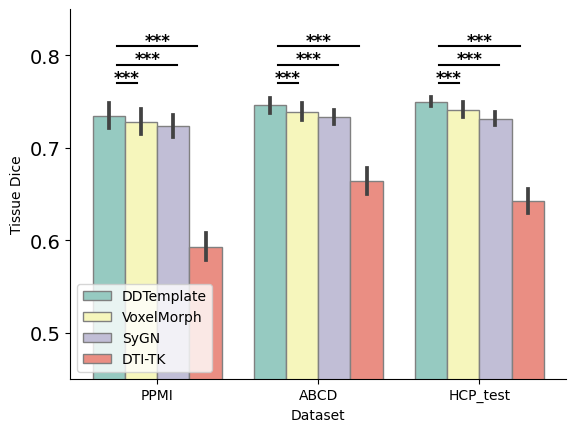

In [5]:

dice_WGC = dice_joint[dice_joint['Tract']=='WGC']
sns.barplot(data=dice_WGC,x='Dataset',y='Dice',hue='Method',palette='Set3',errorbar=('sd',0.5),edgecolor=".5",)
plt.ylim(0.45,0.85)
plt.ylabel('Tissue Dice')
for i, dataset in enumerate(['PPMI','ABCD','HCP_test']):
    ps = []
    df_tract = dice_WGC[dice_WGC['Dataset']==dataset]
    # print(AnovaRM(data=df_tract, depvar='Dice', subject='subid', within=['Method',], aggregate_func='mean').fit())
    mcresult = multicomp.MultiComparison(df_tract['Dice'],df_tract['Method'],group_order=['DDTemplate','VoxelMorph','SyGN','DTI-TK'])
    result = mcresult.tukeyhsd(alpha=0.001)
    print(result)
    plot_pvalues(result.pvalues,plt.gca(),i)
# remove spine upper and right
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.yticks([0.5,0.6,0.7,0.8],fontsize=14)
plt.legend(loc='lower left')

# plt.box(False)
# for method in dice_WGC['Method'].unique():
    # print(f'{method} {mean(dice_WGC[dice_WGC["Method"]==method]["Dice"]):.3f}±{stdev(dice_WGC[dice_WGC["Method"]==method]["Dice"]):.3f}')

/home/junyi/.conda/envs/mainpyenv/lib/python3.9/site-packages/pandas/core/frame.py:5171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


    Multiple Comparison of Means - Tukey HSD, FWER=0.00    
  group1     group2   meandiff p-adj  lower   upper  reject
-----------------------------------------------------------
DDTemplate VoxelMorph  -0.0086   0.0 -0.0112  -0.006   True
DDTemplate       SyGN  -0.0187   0.0 -0.0214 -0.0161   True
DDTemplate     DTI-TK  -0.1076   0.0 -0.1102 -0.1049   True
VoxelMorph       SyGN  -0.0101   0.0 -0.0128 -0.0075   True
VoxelMorph     DTI-TK   -0.099   0.0 -0.1016 -0.0963   True
      SyGN     DTI-TK  -0.0889   0.0 -0.0915 -0.0862   True
-----------------------------------------------------------
    Multiple Comparison of Means - Tukey HSD, FWER=0.00    
  group1     group2   meandiff p-adj  lower   upper  reject
-----------------------------------------------------------
DDTemplate VoxelMorph  -0.0086   0.0 -0.0112  -0.006   True
DDTemplate       SyGN  -0.0187   0.0 -0.0214 -0.0161   True
DDTemplate     DTI-TK  -0.1076   0.0 -0.1102 -0.1049   True
VoxelMorph       SyGN  -0.0101   0.0 -0.

([<matplotlib.axis.YTick at 0x7f78c73af520>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

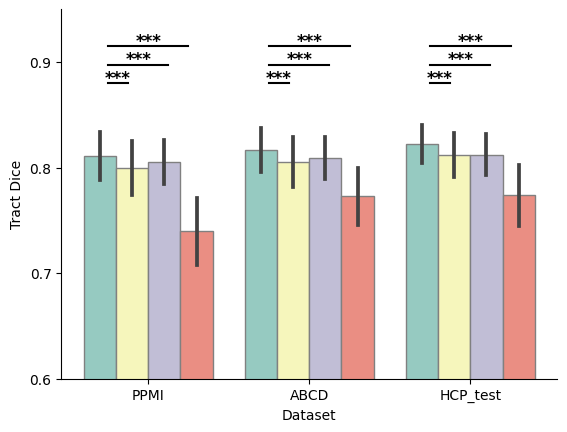

In [7]:
dice_tracts = dice_joint[dice_joint['Tract']!='WGC']
sns.barplot(data=dice_tracts,x='Dataset',y='Dice',hue='Method',palette='Set3',errorbar=('sd',0.5),edgecolor=".5")
plt.ylim(0.6,0.95)
for i, dataset in enumerate(['PPMI','ABCD','HCP_test']):
    ps = []
    df_tract = dice_tracts[dice_tracts['Dataset']==dataset]
    # df_tract = df_tract[df_tract['Method']!='DTITK']
    # print(df_tract)
    df_tract.fillna(0,inplace=True)
    # mcresult = multicomp.MultiComparison(df_tract['Dice'],df_tract['Method'],group_order=['Proposed','VoxelMorph','SyN','DTITK'])
    result = mcresult.tukeyhsd(alpha=0.001)
    print(result)
    plot_pvalues(result.pvalues,plt.gca(),i)
    

# plt.title('Tract Dice')
plt.ylabel('Tract Dice')
plt.legend().remove()
# remove spine upper and right
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.yticks([0.6,0.7,0.8,0.9])


Text(9.444444444444445, 0.5, 'Tissue Dice')

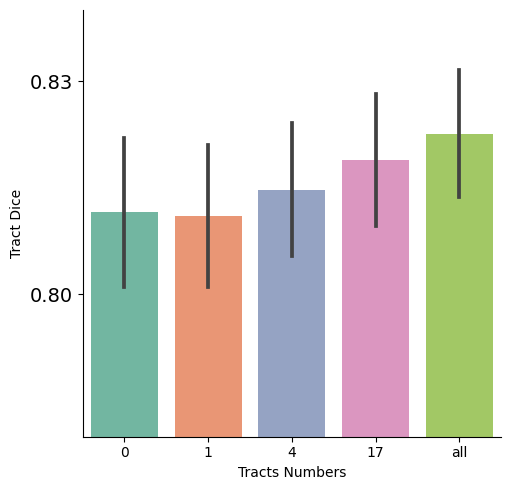

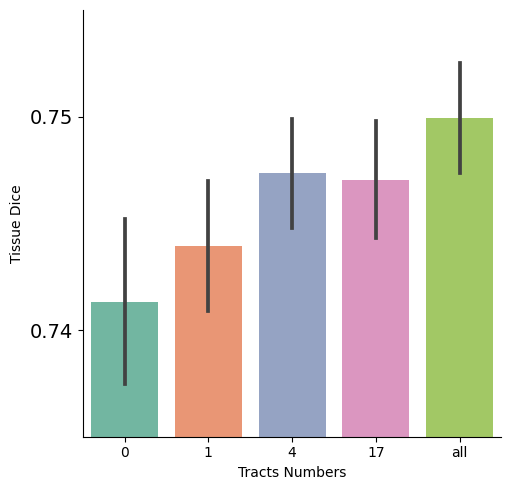

In [15]:
def number(s:str):
    if s == 'Proposed':
        return 'all'
    return int(re.findall(r'\d+',s)[0])

dice_tracts_num = pd.read_csv('./dice_tracts_num_HCP_test.csv')
dice_tracts_num['Tracts Numbers'] = dice_tracts_num['Method'].apply(number)
# dice_tracts_num['Method'] = dice_tracts_num['Method'].replace({'Proposed':'All Tracts',})
dice_tracts_num = dice_tracts_num[dice_tracts_num['Tract']!='FX']
dice_tracts = dice_tracts_num[dice_tracts_num['Tract']!='WGC']
dice_WGC = dice_tracts_num[dice_tracts_num['Tract']=='WGC']
sns.catplot(data=dice_tracts,x='Tracts Numbers',y='Dice',palette='Set2',kind='bar',errorbar=('sd',0.25))
plt.ylabel('Tract Dice')
plt.ylim(0.78,0.84)
plt.yticks([0.8,0.83],fontsize=14)
sns.catplot(data=dice_WGC,x='Tracts Numbers',y='Dice',palette='Set2',kind='bar',errorbar=('sd',0.25))
plt.ylim(0.735,0.755)
plt.yticks([0.74,0.75],fontsize=14)
plt.ylabel('Tissue Dice')

(0.5, 0.95)

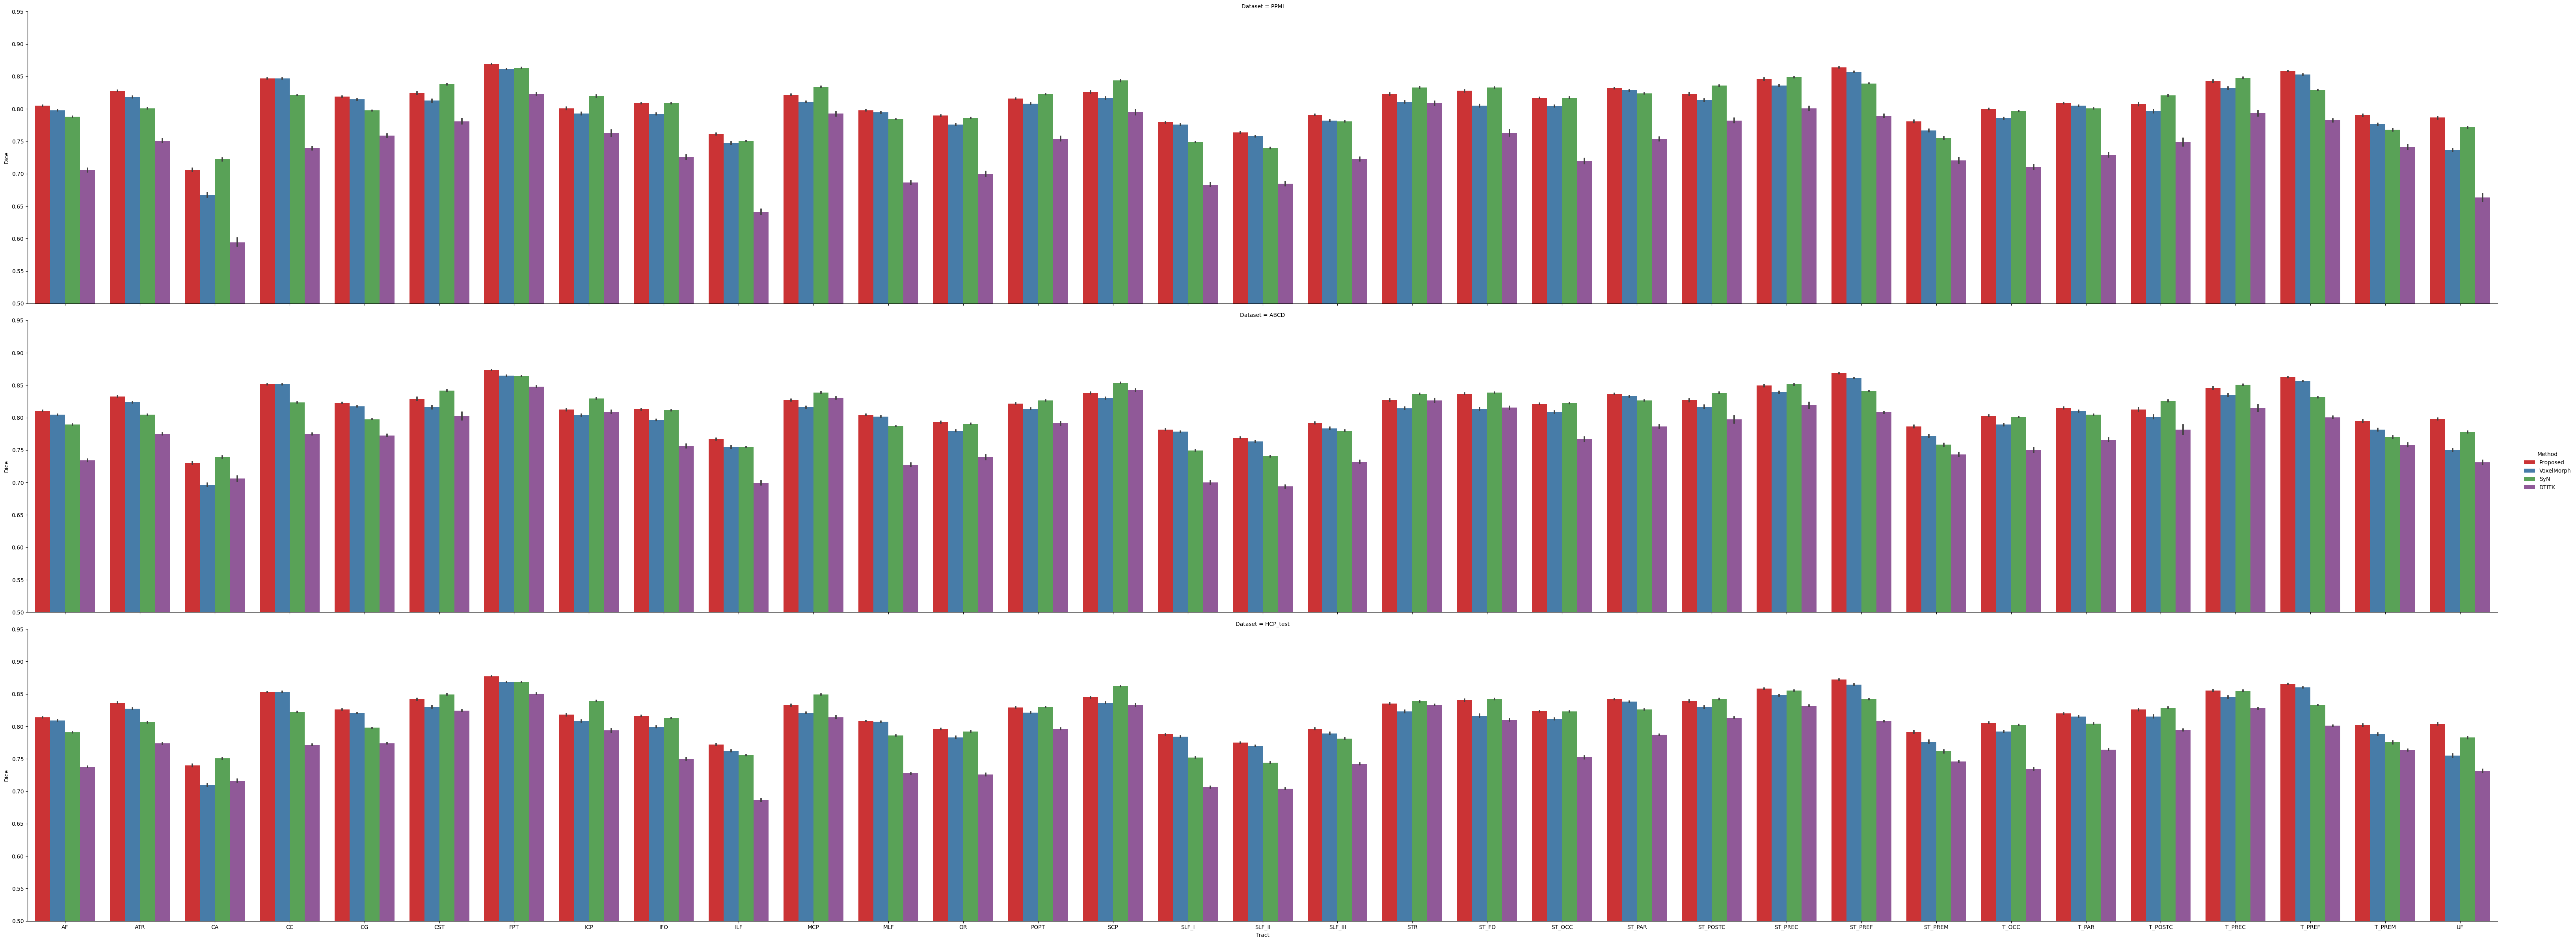

In [175]:
dice_tracts = dice_joint[dice_joint['Tract']!='WGC']
grid = sns.catplot(data=dice_tracts,hue='Method',y='Dice',x='Tract',col='Dataset',col_wrap=1,
            kind='bar',height=8,aspect=8,hue_order=['Proposed','VoxelMorph','SyN','DTITK'],palette='Set1')
plt.ylim(0.5,0.95)

(0.5, 0.95)

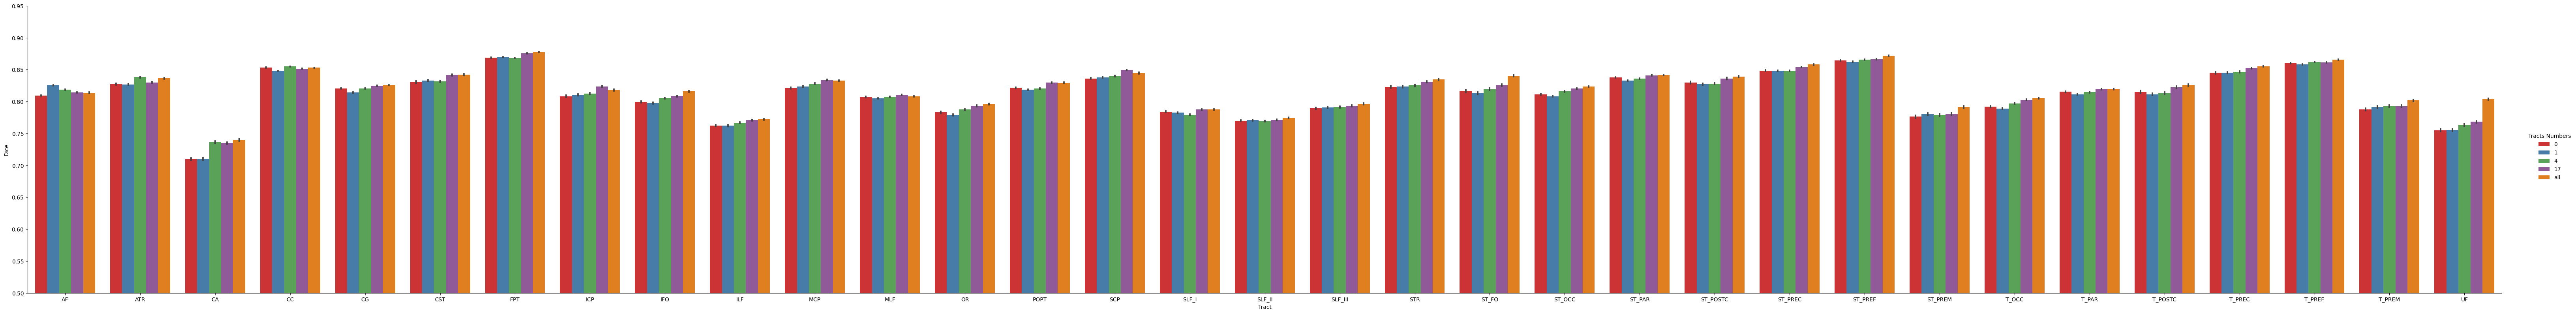

In [148]:
grid = sns.catplot(data=dice_tracts,hue='Tracts Numbers',y='Dice',x='Tract',
            kind='bar',height=8,aspect=8,hue_order=[0,1,4,17,'all'],palette='Set1')
plt.ylim(0.5,0.95)

In [19]:
df_joint = pd.DataFrame()
for dataset in ['PPMI','ABCD','HCP_test']:
    dis_df = pd.read_csv(f'/home/junyi/Documents/scripts/registration/eval/sim_{dataset}.csv',)
    dis_df['Dataset'] = dataset
    df_joint = pd.concat([df_joint,dis_df],axis=0)
df_joint = df_joint[df_joint['Tract']!='FX']
# sorted by Tract
df_joint = df_joint.sort_values(by=['Tract','Method'])
df_joint.replace({'Method':{'ants':'SyN','alltracts':'Proposed','FA_only':'VoxelMorph'}},inplace=True)

    Multiple Comparison of Means - Tukey HSD, FWER=0.00    
  group1     group2   meandiff p-adj  lower   upper  reject
-----------------------------------------------------------
  Proposed VoxelMorph    0.078   0.0  0.0352  0.1207   True
  Proposed        SyN   0.5061   0.0  0.4633  0.5488   True
  Proposed      DTITK  -0.4544   0.0 -0.4979 -0.4109   True
VoxelMorph        SyN   0.4281   0.0  0.3854  0.4708   True
VoxelMorph      DTITK  -0.5324   0.0 -0.5759 -0.4889   True
       SyN      DTITK  -0.9605   0.0  -1.004  -0.917   True
-----------------------------------------------------------


NameError: name 'plot_pvalues' is not defined

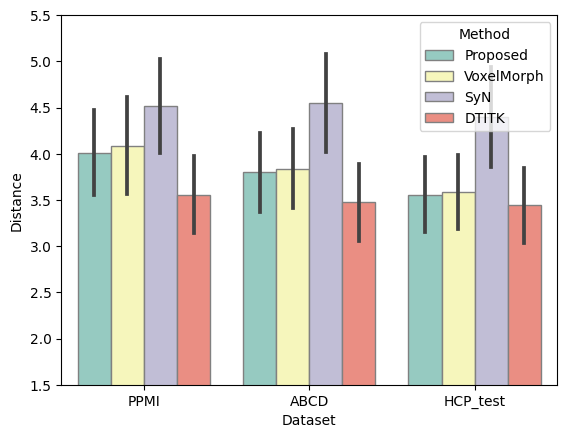

In [20]:
df_joint.columns = ['sub_id','ShapeSim','Distance','Tract','Method','Dataset',]
fig = sns.barplot(data=df_joint,x='Dataset',y='Distance',hue='Method',palette='Set3',errorbar=('sd',0.5),edgecolor=".5",hue_order=['Proposed','VoxelMorph','SyN','DTITK'],order=['PPMI','ABCD','HCP_test'],)
plt.ylim(1.5,5.5)
plt.ylabel('Distance')
plt.xlabel('Dataset')
for i, dataset in enumerate(df_joint['Dataset'].unique()):
    # print(f'{method} {mean(df_joint[df_joint["Method"]==method]["Distance"]):.3f}±{stdev(df_joint[df_joint["Method"]==method]["Distance"]):.3f}')
    df_tract = df_joint[df_joint['Dataset']==dataset]
    df_tract = df_tract.dropna()
    mcresult = multicomp.MultiComparison(df_tract['Distance'],df_tract['Method'],group_order=['Proposed','VoxelMorph','SyN','DTITK'])
    result = mcresult.tukeyhsd(alpha=0.001)
    print(result)
    plot_pvalues(result.pvalues,fig,i)
# remove legend
plt.legend().remove()
# plt.legend()
# remove upper and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# improve quality
plt.savefig('joint_shape_dist.png',dpi=300)
plt.yticks([2,3,4,5])
# plt.legend(title='Method',loc='lower right')

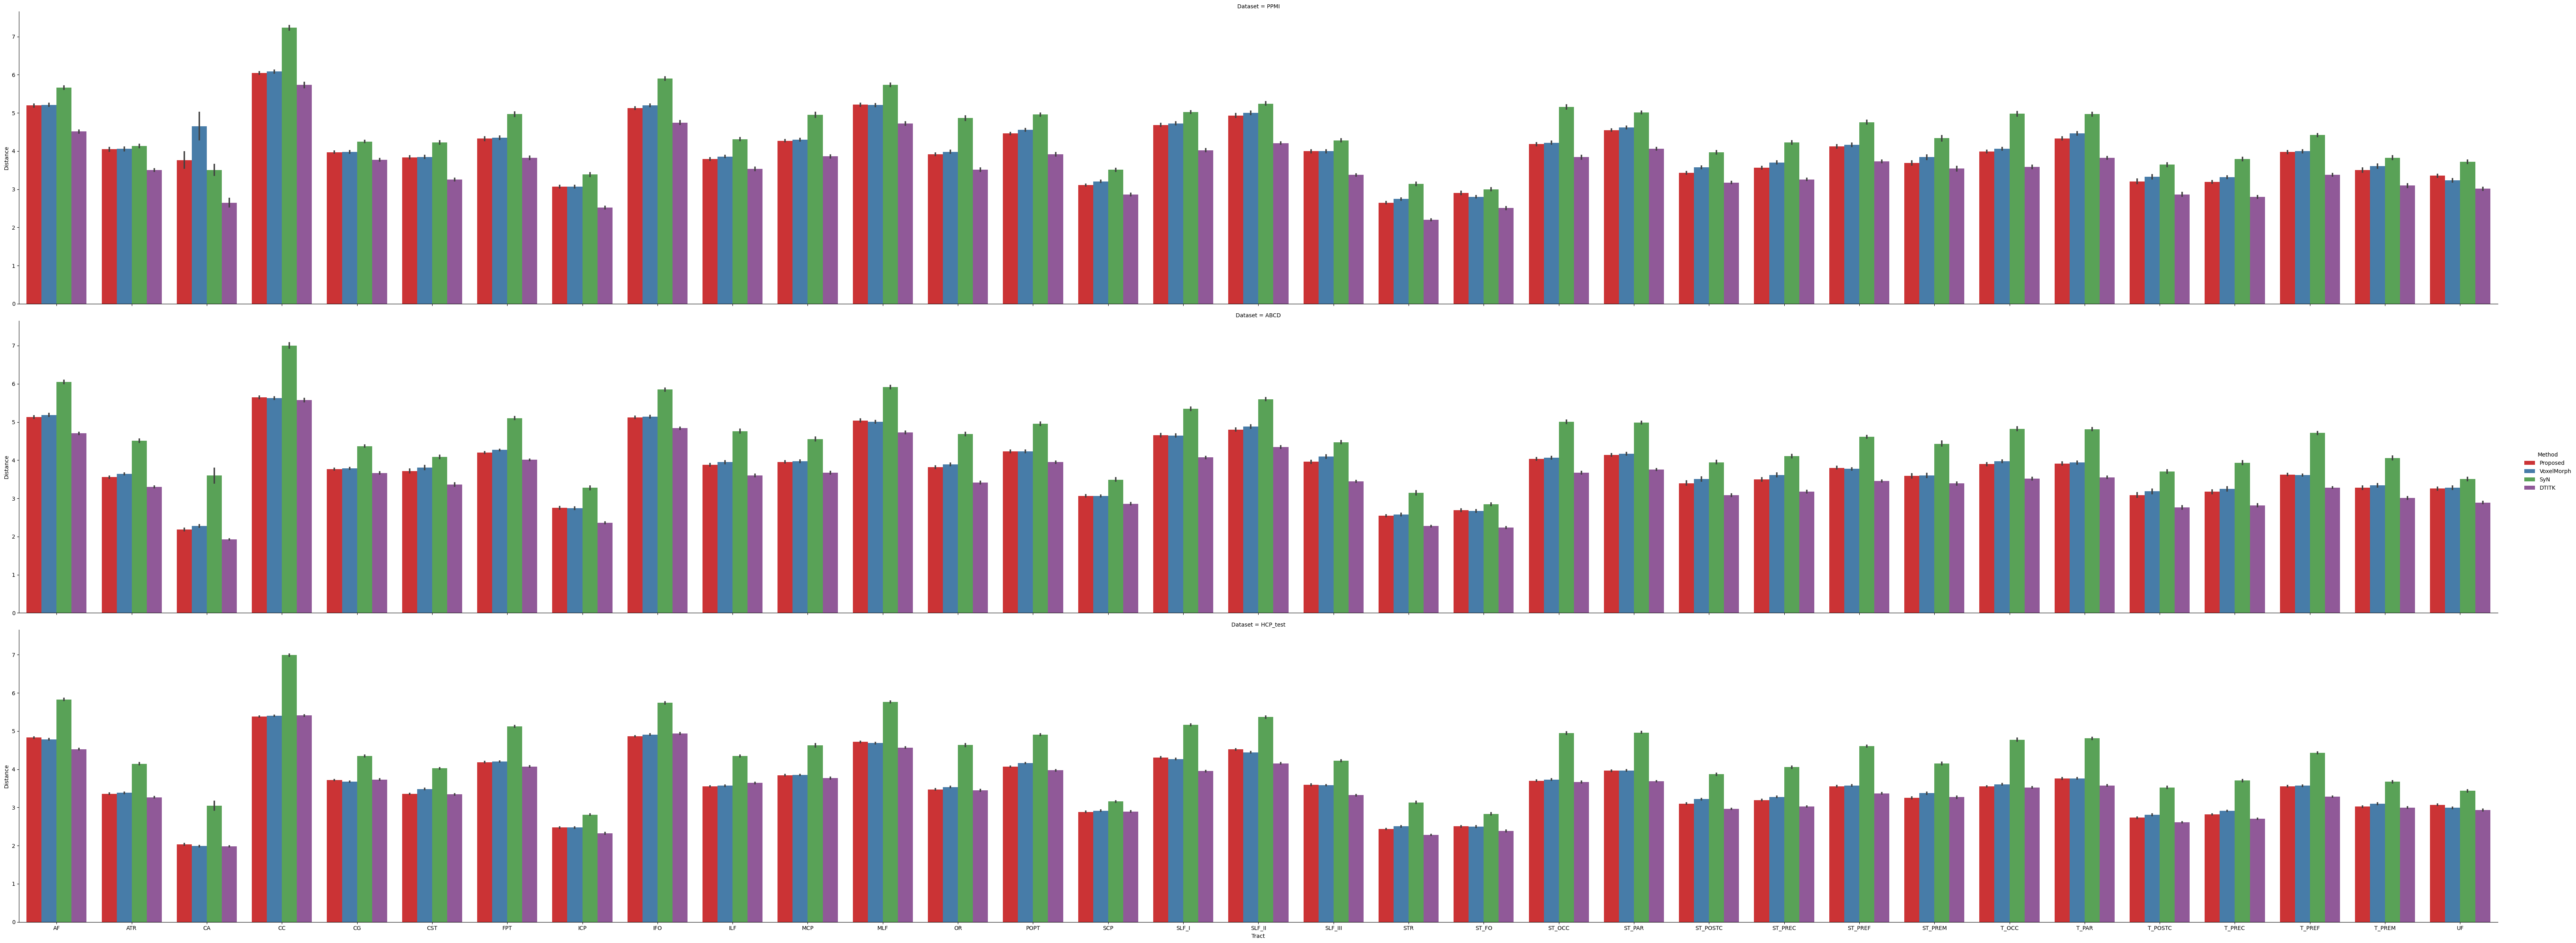

In [21]:
df_tracts = df_joint
grid = sns.catplot(data=df_tracts,hue='Method',y='Distance',x='Tract',col='Dataset',col_wrap=1,
            kind='bar',height=8,aspect=8,hue_order=['Proposed','VoxelMorph','SyN','DTITK'],palette='Set1')


In [40]:
Im = nib.load('/data04/junyi/results/tracts_related/flow_alltracts_HCP_test/SUB000.nii.gz')
data,affine = Im.get_fdata(),Im.affine
data*= 1.25
print(data.shape,affine)
print(affine)
Im_new = nib.Nifti1Image(data,affine,Im.header)
nib.save(Im_new,'./SUB000.nii.gz')

(145, 174, 145, 1, 3) [[  -1.25    0.      0.     90.  ]
 [   0.      1.25    0.   -126.  ]
 [   0.      0.      1.25  -72.  ]
 [   0.      0.      0.      1.  ]]
[[  -1.25    0.      0.     90.  ]
 [   0.      1.25    0.   -126.  ]
 [   0.      0.      1.25  -72.  ]
 [   0.      0.      0.      1.  ]]


In [179]:
def plot_pvalues(ps,fig,i):
    # coords = [[i-0.25,i],[i-0.25,i+0.25],[i,i+0.25],]
    coords = [[i-0.25,i-0.125],[i-0.25,i+0.125],[i-0.25,i+0.25],]
    low, high = fig.get_ylim()
    for j, p  in enumerate(ps):
        
        height = low + ((j/3)*0.1 + 0.9)*(1.1-low)
        if p < 0.001 or 1-p < 0.001:
            text = '***'
        elif p < 0.01 or 1-p < 0.01:
            text = '**'
        elif p < 0.05 or 1-p < 0.05:  
            text = '*'
        else:
            text = 'n.s.'
        fig.plot(coords[j],[height,height],color='black',linewidth=1.5)
        if text == 'n.s.':
            height *= 1.005
        fig.text(np.sum(coords[j])/2,height,text,ha='center',fontdict={'weight':'bold','color':'black','size':12,})
        if j>=2:
            break

    Multiple Comparison of Means - Tukey HSD, FWER=0.00     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
  Proposed VoxelMorph  -0.0052 0.0003 -0.0099 -0.0004   True
  Proposed        SyN  -0.0657    0.0 -0.0705 -0.0609   True
  Proposed      DTITK   0.0403    0.0  0.0354  0.0451   True
VoxelMorph        SyN  -0.0605    0.0 -0.0653 -0.0558   True
VoxelMorph      DTITK   0.0454    0.0  0.0406  0.0503   True
       SyN      DTITK    0.106    0.0  0.1011  0.1108   True
------------------------------------------------------------
    Multiple Comparison of Means - Tukey HSD, FWER=0.00     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
  Proposed VoxelMorph  -0.0037 0.0086 -0.0081  0.0007  False
  Proposed        SyN  -0.0942    0.0 -0.0986 -0.0898   True
  Proposed      DTITK   0.0273    0.0   0.023  0.0317   True
VoxelMorph        SyN  -

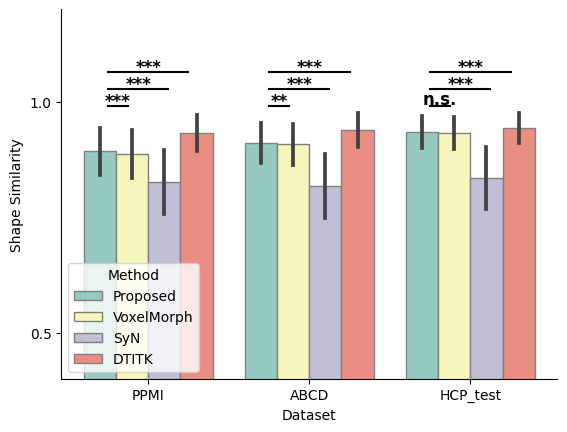

In [180]:
# df_joint.columns = ['sub_id','ShapeSim','Distance','Tract','Method','Dataset',]
fig = sns.barplot(data=df_joint,x='Dataset',y='ShapeSim',hue='Method',palette='Set3',errorbar=('sd',0.5),edgecolor=".5",hue_order=['Proposed','VoxelMorph','SyN','DTITK'],order=['PPMI','ABCD','HCP_test'],)

plt.ylabel('Shape Similarity')
plt.xlabel('Dataset')
for i, dataset in enumerate(['PPMI','ABCD','HCP_test']):
    # print(f'{method} {mean(df_joint[df_joint["Method"]==method]["Distance"]):.3f}±{stdev(df_joint[df_joint["Method"]==method]["Distance"]):.3f}')
    df_tract = df_joint[df_joint['Dataset']==dataset]
    df_tract = df_tract.dropna()
    # for tract in df['Tract'].unique():
    #     df_tract = df[df['Tract']==tract]
    #     print(tract)
    # print(AnovaRM(data=df_tract, depvar='ShapeSim', subject='sub_id', within=['Method',], aggregate_func='mean').fit())
    mcresult = multicomp.MultiComparison(df_tract['ShapeSim'],df_tract['Method'],group_order=['Proposed','VoxelMorph','SyN','DTITK'])
    result = mcresult.tukeyhsd(alpha=0.001)
    print(result)
    plot_pvalues(result.pvalues,fig,i)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylim(0.4,1.2)
# set yticks > 1 unvisible
plt.gca().set_yticks([0.5,1,])

    

    Multiple Comparison of Means - Tukey HSD, FWER=0.00    
  group1     group2   meandiff p-adj  lower   upper  reject
-----------------------------------------------------------
DDTemplate VoxelMorph  -0.0086   0.0 -0.0112  -0.006   True
DDTemplate       SyGN  -0.0187   0.0 -0.0214 -0.0161   True
DDTemplate     DTI-TK  -0.1076   0.0 -0.1102 -0.1049   True
VoxelMorph       SyGN  -0.0101   0.0 -0.0128 -0.0075   True
VoxelMorph     DTI-TK   -0.099   0.0 -0.1016 -0.0963   True
      SyGN     DTI-TK  -0.0889   0.0 -0.0915 -0.0862   True
-----------------------------------------------------------


Text(9.444444444444445, 0.5, '')

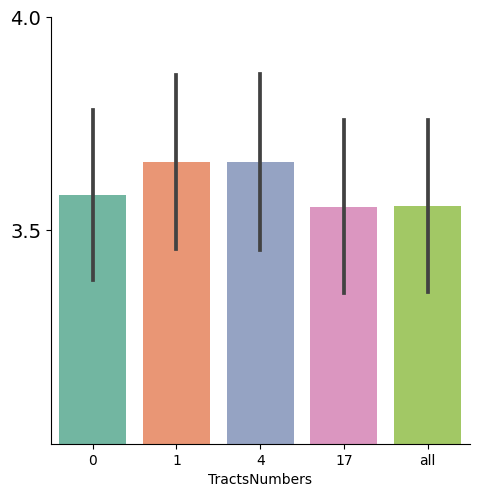

In [14]:
df = pd.read_csv(f'/home/junyi/Documents/scripts/registration/eval/sim_tracts_num.csv')
df_HCP = pd.read_csv(f'/home/junyi/Documents/scripts/registration/eval/sim_HCP_test.csv')
df_new = pd.concat([df,df_HCP],axis=0).replace({'Method':{'alltracts':"all",'FA_only':0},})
df_new = df_new[df_new['Method']!='ants']
df_new = df_new[df_new['Method']!='DTITK']
df_new['Tracts Numbers'] = df_new['Method']
df_new.columns = ['sub_id','ShapeSim','Distance','Tract','Method','TractsNumbers',]
df_new = df_new[(df_new['Tract']!='FX')]
# print(AnovaRM(data=df_new, depvar='Distance', subject='sub_id', within=['TractsNumbers',], aggregate_func='mean').fit())
df_new = df_new.dropna()
df_new.TractsNumbers = df_new.TractsNumbers.astype(str)
# mcresult = multicomp.MultiComparison(df_new['Distance'],df_new['TractsNumbers'],group_order=['all','0','1','4','17'])
# result = mcresult.tukeyhsd(alpha=0.01)
print(result)
sns.catplot(data=df_new,x='TractsNumbers',y='Distance',palette='Set2',kind='bar',errorbar=('sd',0.25),order=['0','1','4','17','all'])
plt.ylim(3,4.0)
plt.yticks([3.5,4.0],fontsize=14)
plt.ylabel('')

In [38]:
print(result)

                      Multiple Comparison of Means - Tukey HSD, FWER=0.00                      
group1 group2 meandiff p-adj lower upper reject
-----------------------------------------------
-----------------------------------------------------------------------------------------------


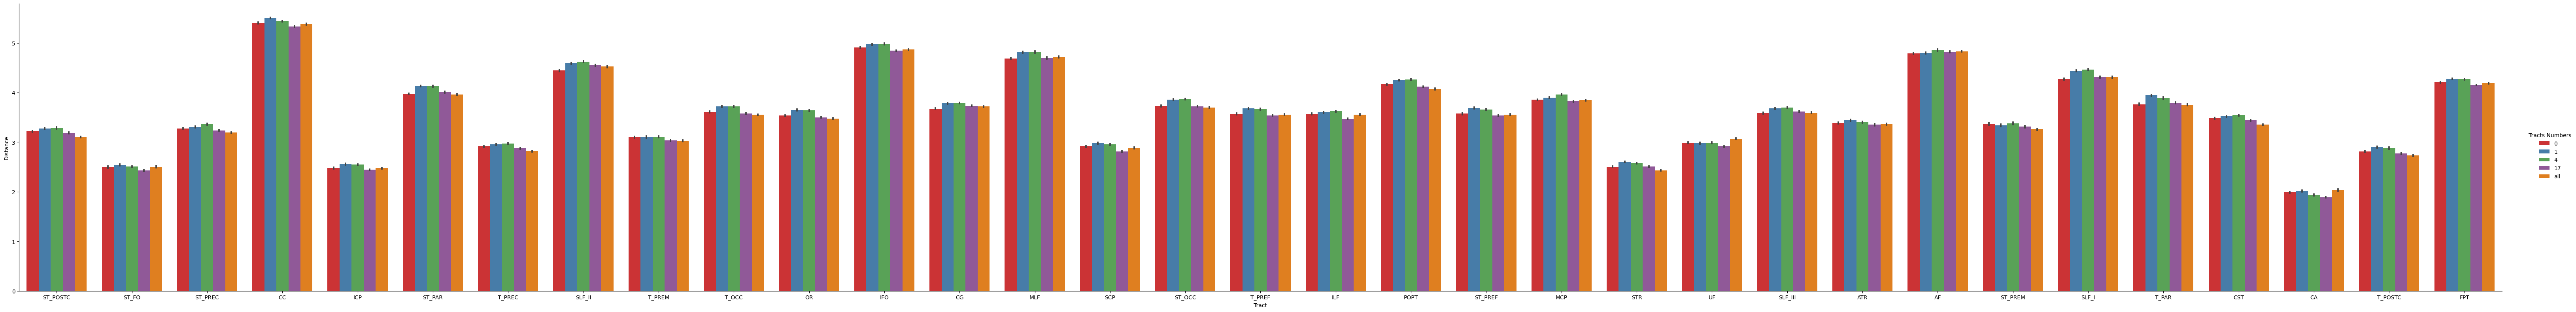

In [150]:
grid = sns.catplot(data=df_new,hue='Tracts Numbers',y='Distance',x='Tract',
            kind='bar',height=8,aspect=8,hue_order=[0,1,4,17,'all'],palette='Set1')


Text(9.444444444444445, 0.5, 'Shape Similarity')

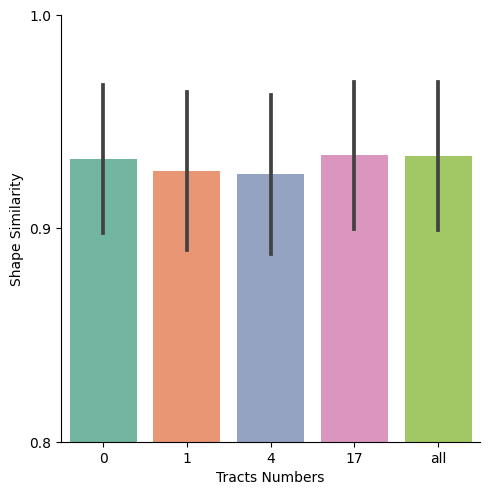

In [134]:
sns.catplot(data=df_new,x='Tracts Numbers',y='ShapeSim',palette='Set2',kind='bar',errorbar=('sd',0.5),order=[0,1,4,17,'all'])
plt.ylim(0.8,1)
plt.yticks([0.8,0.9,1])
plt.ylabel('Shape Similarity')


(0.7, 1.0)

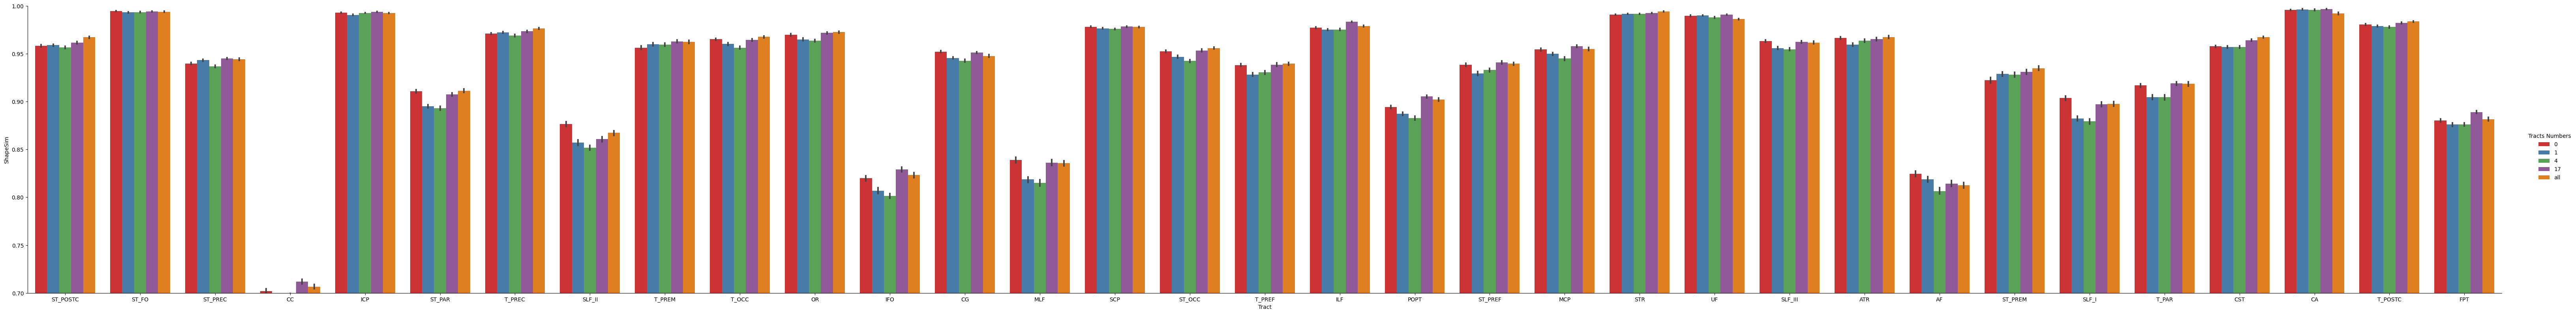

In [153]:
grid = sns.catplot(data=df_new,hue='Tracts Numbers',y='ShapeSim',x='Tract',
            kind='bar',height=8,aspect=8,hue_order=[0,1,4,17,'all'],palette='Set1')
plt.ylim(0.7,1)